In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [2]:
data = yf.download(['AMD', 'NVDA'], start='2020-01-01', end='2020-06-01')

[*********************100%%**********************]  2 of 2 completed


In [3]:
close = data.Close
close

,AMD,NVDA
Date,,
2020-01-02,49.099998,59.977501
2020-01-03,48.599998,59.017502
2020-01-06,48.389999,59.264999
2020-01-07,48.250000,59.982498
2020-01-08,47.830002,60.095001
...,...,...
2020-05-22,55.169998,90.262497
2020-05-26,53.189999,87.177498
2020-05-27,52.740002,85.252502


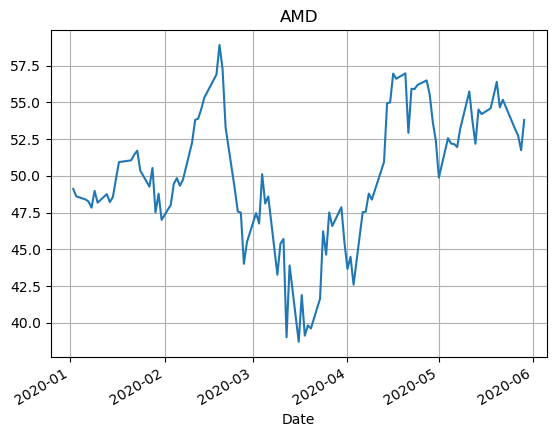

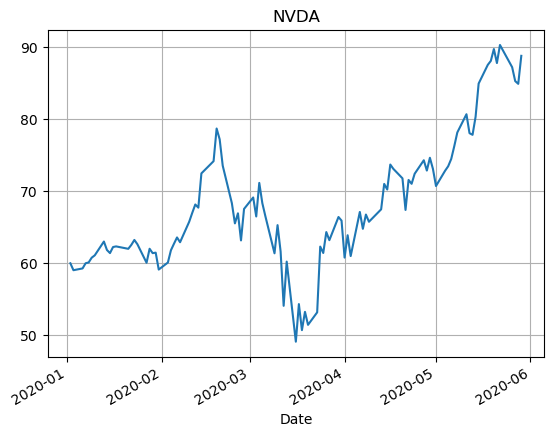

In [4]:
for name in close.columns:
    close[name].plot()
    plt.grid()
    plt.title(name)
    plt.show()

In [5]:
profit = close.pct_change()
profitMean = profit.mean()
profitMean

AMD     0.001894
NVDA    0.004991
dtype: float64

In [6]:
cov = profit.cov().to_numpy()
cov

array([[0.00199638, 0.00186873],
       [0.00186873, 0.00228562]])

In [7]:
cnt = len(profit.columns)

def randPortf():
    res = np.exp(np.random.randn(cnt))
    res = res / res.sum()
    return res

r = randPortf()
print(r)
print(r.sum())

[0.39657013 0.60342987]
1.0


In [8]:
def profitPortf(r):
    return np.matmul(profitMean.values, r)

r = randPortf()
print(r)
d = profitPortf(r)  # returns
print(d)

[0.23863173 0.76136827]
0.004251684103882651


In [9]:
def riskPortf(r):
    return np.sqrt(np.matmul(np.matmul(r, cov), r))

r = randPortf()    
print(r)
rs = riskPortf(r)  # risks
print(rs)

[0.38715185 0.61284815]
0.0452154982813802


In [16]:
def sharpeRatio(Rp, Rf, sigmap):
    return (Rp - Rf) / sigmap

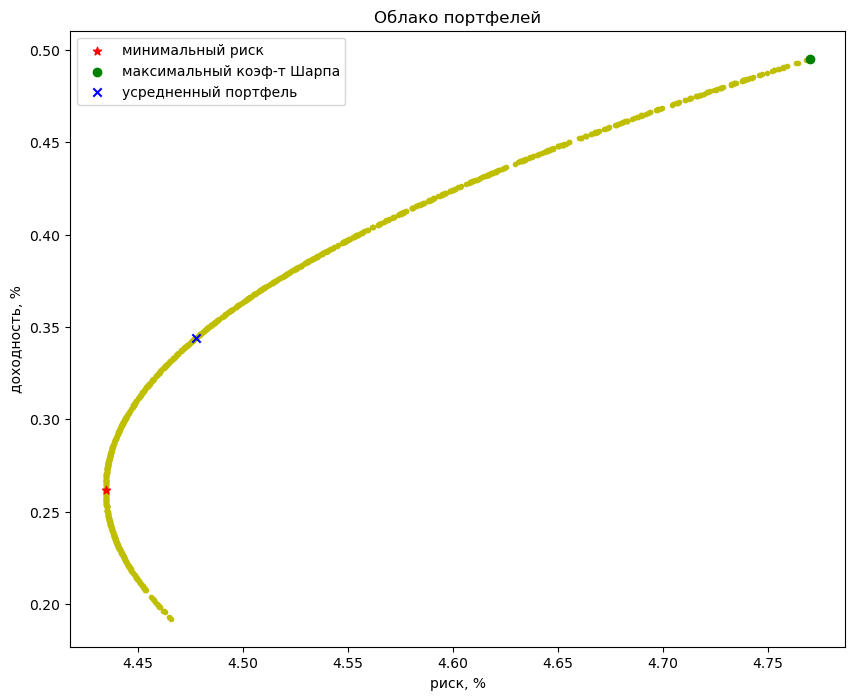

In [17]:
N = 1024
risk = np.zeros(N)
doh = np.zeros(N)
portf = np.zeros((N,cnt))

sharpeK = np.zeros(N)

riskFree = 0.03

for n in range(N):
    r = randPortf()

    portf[n,:] = r
    risk[n] = riskPortf(r)
    doh[n] = profitPortf(r)
    sharpeK[n] = sharpeRatio(np.sum(r * profitPortf(r)),
                             riskFree,
                             np.dot(r.T, np.dot(cov, r)))
    
plt.figure(figsize=(10,8))

plt.scatter(risk*100,doh*100,c='y',marker='.')
plt.xlabel('риск, %')
plt.ylabel('доходность, %')
plt.title("Облако портфелей")

min_risk = np.argmin(risk)
plt.scatter([(risk[min_risk])*100],[(doh[min_risk])*100],c='r',marker='*',label='минимальный риск')

maxSharpKoef = np.argmax(doh/risk)
plt.scatter([risk[maxSharpKoef]*100],[doh[maxSharpKoef]*100],c='g',marker='o',label='максимальный коэф-т Шарпа')

r_mean = np.ones(cnt)/cnt
risk_mean = riskPortf(r_mean)
doh_mean = profitPortf(r_mean)
plt.scatter([risk_mean*100],[doh_mean*100],c='b',marker='x',label='усредненный портфель')

plt.legend()

plt.show()

In [12]:
print('Min risk')
print("риск = %1.2f%%" % (float(risk[min_risk])*100.))
print("доходность = %1.2f%%" % (float(doh[min_risk])*100.))
print(pd.DataFrame([portf[min_risk]*100],columns=close.columns,index=['доли, %']).T)
print()

print('Max Sharpe coefficent')
print("риск = %1.2f%%" % (float(risk[maxSharpKoef])*100.))
print("доходность = %1.2f%%" % (float(doh[maxSharpKoef])*100.))
print()
print(pd.DataFrame([portf[maxSharpKoef]*100],columns=close.columns,index=['доли, %']).T)
print()

print('Medium portfolio')
print("риск = %1.2f%%" % (float(risk_mean)*100.))
print("доходность = %1.2f%%" % (float( doh_mean)*100.))
print()
print(pd.DataFrame([r_mean*100],columns=close.columns,index=['доли, %']).T)
print()

Min risk
риск = 4.43%
доходность = 0.26%
        доли, %
AMD   76.564024
NVDA  23.435976

Max Sharpe coefficent
риск = 4.77%
доходность = 0.49%

        доли, %
AMD    1.435447
NVDA  98.564553

Medium portfolio
риск = 4.48%
доходность = 0.34%

      доли, %
AMD      50.0
NVDA     50.0



Text(0.5, 0, 'Sharpe Ratio')

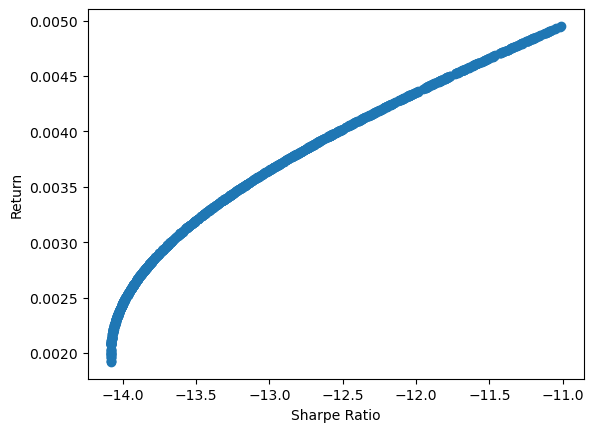

In [21]:
plt.scatter(sharpeK, doh)
plt.ylabel('Return')
plt.xlabel('Sharpe Ratio')